# Inconsistency of Bayesian Inference for Missspecified Linear Models, and a proposal for repairing it.

<span style="color:red"> We attemped to implement the standard linear model $\mathcal{M}_p$ with fixed $p$ as used in the paper. However we do not observe any noticable influence of the dimention $p$ and the temperature $\eta$. </br>
This is most likely due to an implementation error on our part.</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

## Reproducing the paper's dataset:

In [2]:
def toyDataSet(n, sigma2=1, model_wrong = True):
    """
    :arg n: dataset size.
    :arg sigma2: std of the Gaussian noise
    """
    dataset = []
    for i in range(n):
        coin_flip = np.random.rand()
        if model_wrong and coin_flip < .5:
            x = np.random.normal(0, 1)
            y = np.random.normal(0, sigma2)
            dataset.append((x,y))
        else:
            dataset.append((0,0))
    return np.array(dataset)

### Example display:

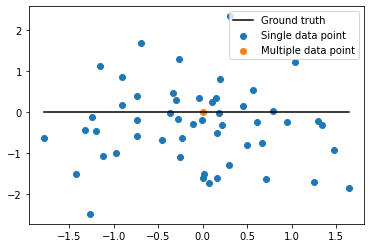

In [3]:
data = toyDataSet(100)

plt.scatter(data[np.where(data[:,0] !=0),0], data[np.where(data[:,0] !=0),1], label="Single data point")
plt.scatter(0, 0, label="Multiple data point")
plt.plot([data[:,0].min(), data[:,0].max()], [0, 0], color="black", label="Ground truth")
plt.legend()
plt.savefig('toy_dataset.png')

## Reproduce the paper's standard linear model

In [4]:
class standard_linear_model:
    def __init__(self, p, eta=1, beta_prior_mean=None, beta_prior_sgm=None, sigma2_prior_a=1, sigma2_prior_b=.1):
        self.p = p
        self.eta = eta
        # priors:
        self.beta_prior_mean = np.zeros(p) if beta_prior_mean==None else beta_prior_mean
        self.beta_prior_sgm = np.eye(p) if beta_prior_sgm==None else beta_prior_sgm
        self.sigma2_prior_a = sigma2_prior_a
        self.sigma2_prior_b = sigma2_prior_b
        # posteriors:
        self.betas = None
        self.sigma2 = None
        
    def fit(self, X, y):
        n,d = X.shape
        epsilon_n_eta = np.linalg.inv(np.eye(d) + self.eta*X.T@X)
        beta_bar = epsilon_n_eta@((np.eye(d)@self.beta_prior_mean).reshape(-1,1) + self.eta*X.T@y)
        beta_cov = self.beta_prior_sgm@epsilon_n_eta
        self.betas = np.random.multivariate_normal(beta_bar.flatten(), beta_cov)
        a = self.sigma2_prior_a + self.eta*n/2
        b = self.sigma2_prior_b + self.eta/2 * np.sum((y - X@beta_bar)**2)
        self.sigma2 = b/(a-1)
        
    def predict(self, X):
        return X@self.betas + np.random.normal(0, self.sigma2, X.shape[0])

### Plot examples

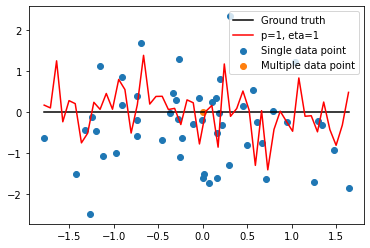

In [5]:
m = standard_linear_model(1)
m.fit(data[:,0].reshape(-1, 1), data[:,1].reshape(-1, 1))

plt.scatter(data[np.where(data[:,0] !=0),0], data[np.where(data[:,0] !=0),1], label="Single data point")
plt.scatter(0, 0, label="Multiple data point")
plt.plot([data[:,0].min(), data[:,0].max()], [0, 0], color="black", label="Ground truth")
plt.plot(np.linspace(data[:,0].min(), data[:,0].max(), 50), m.predict(np.linspace(data[:,0].min(), data[:,0].max(), 50).reshape(-1,1)), color='red', label="p=1, eta=1")
plt.legend()

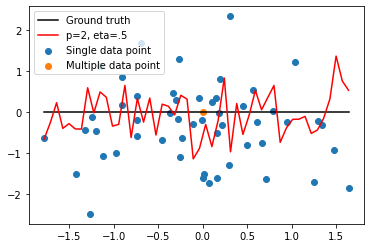

In [6]:
p = 2
eta=.5
m = standard_linear_model(p, eta)
m.fit(np.concatenate([data[:,0].reshape(-1, 1) for i in range(p)], axis=1), data[:,1].reshape(-1, 1))



plt.scatter(data[np.where(data[:,0] !=0),0], data[np.where(data[:,0] !=0),1], label="Single data point")
plt.scatter(0, 0, label="Multiple data point")
plt.plot([data[:,0].min(), data[:,0].max()], [0, 0], color="black", label="Ground truth")
plt.plot(np.linspace(data[:,0].min(), data[:,0].max(), 50), m.predict(np.concatenate([np.linspace(data[:,0].min(), data[:,0].max(), 50).reshape(-1,1) for i in range(p)], axis=1)), color='red', label="p=2, eta=.5")
plt.legend()

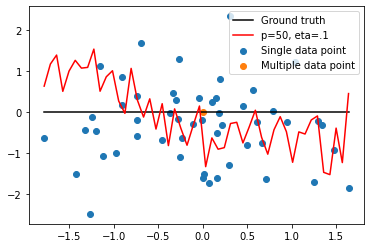

In [7]:
p = 50
eta = .1
m = standard_linear_model(p, eta)
m.fit(np.concatenate([data[:,0].reshape(-1, 1) for i in range(p)], axis=1), data[:,1].reshape(-1, 1))



plt.scatter(data[np.where(data[:,0] !=0),0], data[np.where(data[:,0] !=0),1], label="Single data point")
plt.scatter(0, 0, label="Multiple data point")
plt.plot([data[:,0].min(), data[:,0].max()], [0, 0], color="black", label="Ground truth")
plt.plot(np.linspace(data[:,0].min(), data[:,0].max(), 50), m.predict(np.concatenate([np.linspace(data[:,0].min(), data[:,0].max(), 50).reshape(-1,1) for i in range(p)], axis=1)), color='red', label="p=50, eta=.1")
plt.legend()

## Main experiment:

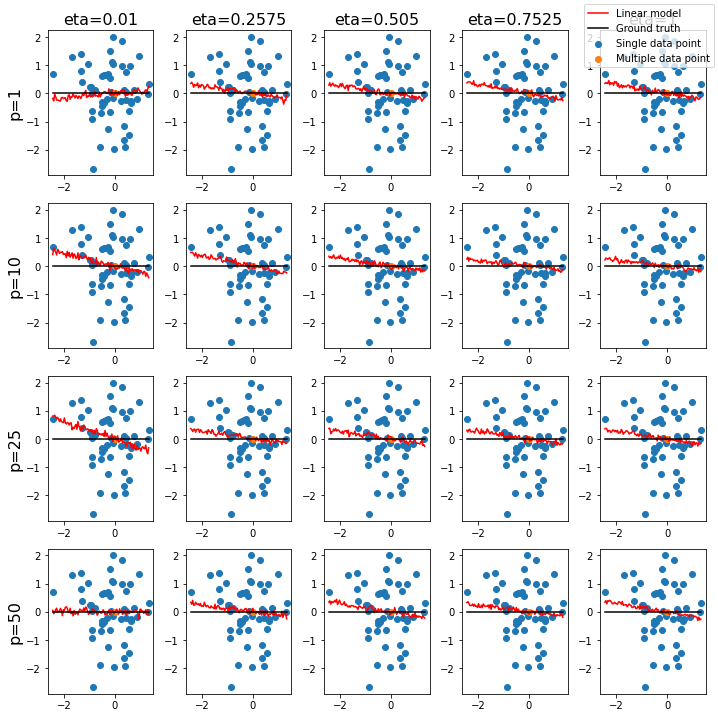

In [8]:
p_values = [1, 10, 25, 50]
eta_values = np.linspace(.01,1,5)
nb_runs = 100
data = toyDataSet(100)
lin_x = np.linspace(data[:,0].min(), data[:,0].max(), 100)

fig,ax = plt.subplots(4,5, figsize=(10,10))
legend_flag = 0

for p_i in range(len(p_values)):
    p = p_values[p_i]
    for eta_i in range(len(eta_values)):
        eta = eta_values[eta_i]
        lin_y = []
        for run in range(nb_runs):
            m = standard_linear_model(p, eta)
            m.fit(np.concatenate([data[:,0].reshape(-1, 1) for i in range(p)], axis=1), data[:,1].reshape(-1, 1))
            lin_y.append(m.predict(np.concatenate([np.linspace(data[:,0].min(), data[:,0].max(), 100).reshape(-1,1) for i in range(p)], axis=1)))
        lin_y = np.array(lin_y).mean(axis=0)
        ax[p_i, eta_i].plot(lin_x, lin_y, color='red', label="Linear model" if legend_flag==0 else None)
        ax[p_i, eta_i].scatter(data[np.where(data[:,0] !=0),0], data[np.where(data[:,0] !=0),1], label="Single data point" if legend_flag==0 else None)
        ax[p_i, eta_i].scatter(0, 0, label="Multiple data point" if legend_flag==0 else None)
        ax[p_i, eta_i].plot([data[:,0].min(), data[:,0].max()], [0, 0], color="black", label="Ground truth" if legend_flag==0 else None)
        legend_flag = 1

ax[0,0].set_title("eta=0.01", fontsize=16)
ax[0,1].set_title("eta=0.2575", fontsize=16)
ax[0,2].set_title("eta=0.505", fontsize=16)
ax[0,3].set_title("eta=0.7525", fontsize=16)
ax[0,4].set_title("eta=1", fontsize=16)
ax[0,0].set_ylabel("p=1", fontsize=16)
ax[1,0].set_ylabel("p=10", fontsize=16)
ax[2,0].set_ylabel("p=25", fontsize=16)
ax[3,0].set_ylabel("p=50", fontsize=16)
        
fig.legend()
fig.tight_layout()
fig.savefig('main experiment.png')